## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important to get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability



In [118]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [119]:
#import data into jupyter book
df=pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [120]:
# get the number pf rows 
df.shape[0]

294478

In [121]:
# the number of unique uses
df.user_id.nunique()

290584

In [122]:
# proportion of users converted
df_converted=df.query('converted==1').count()
proportion_users_converted=df_converted/df.shape[0]
proportion_users_converted[0]

0.11965919355605512

In [123]:
# only get number of missleading  
df.landing_page.unique()
df_old_page_treatment=df.query('group == "treatment" and landing_page== "old_page"').count()
df_new_page_control=df.query('group == "control" and landing_page== "new_page"').count()
(df_old_page_treatment+df_new_page_control)[0]

3893

In [124]:
# check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [126]:
#create a new dataframe only included treatment with new page and control with old page
df_new_page_treatment=df.query('group == "treatment" and landing_page== "new_page"')
df_old_page_control=df.query('group == "control" and landing_page== "old_page"')
df2=pd.concat([df_new_page_treatment,df_old_page_control])
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [127]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [128]:
#check unique id
df2.user_id.nunique()

290584

In [129]:
#find duplicated id
repeated_id=pd.concat(g for _, g in df2.groupby("user_id") if len(g) > 1)

In [130]:

repeated_id.user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

In [131]:
# take a look repeat user_id rows
repeated_id

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [132]:
#remove dulicated based on user_id
df2.drop_duplicates(subset='user_id',inplace=True)
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [133]:
# regardless of page, the number of converted
df2.query('converted == 1').count()[0]/df2.shape[0]

0.11959708724499628

In [134]:
# the number of converted in control group
ob_old=df2.query('converted == 1 and group == "control" ').count()[0]/df2.query('group =="control"').count()[0]

In [135]:
# the number of converted in treatment group
ob_new=df2.query('converted == 1 and group == "treatment" ').count()[0]/df2.query('group =="treatment"').count()[0]

In [136]:
# the proportion of new page
df2.query('landing_page=="new_page"').count()[0]/df2.shape[0]

0.50006194422266881

** we are not able to say one page leads to the other since the porportion on new page and old page is 
 almost same. In addition, there are some factor such as time which did not take into consideration.**
    

<a id='ab_test'></a>
### Part II - A/B Test




$$H_0:p_{new}<=p_{old}$$
$$H_1:p_{new}>p_{old}$$

In [137]:
#convert rate for  pnewpnew  
df_converted=df.query('converted==1').count()
proportion_users_converted=df_converted/df.shape[0]
p_new=proportion_users_converted[0]

In [138]:
#convert rate for  poldpold 
df_converted=df.query('converted==1').count()
proportion_users_converted=df_converted/df.shape[0]
p_old=proportion_users_converted[0]

In [139]:
# the number of new page
N_new=df2.query('landing_page =="new_page"').count()[0]

In [140]:
# the number of old page
N_old=df2.query('landing_page =="old_page"').count()[0]

In [141]:
# the proportion of new page has been converted 
new_page_coverted=np.random.choice([0,1],size=N_new,p=[1-p_new,p_new])
new_page_coverted.mean()

0.12111348152226274

In [142]:
# the proportion of old page has been converted 
old_page_coverted=np.random.choice([0,1],size=N_old,p=[1-p_old,p_old])
old_page_coverted.mean()

0.11854839819926484

In [143]:
# get the difference
new_page_coverted.mean()-old_page_coverted.mean()

0.002565083322997902

In [144]:
# do bootstaping simulate 10000 times
p_diffs=[]
for i in range(10000):
    new_page_coverted=np.random.choice([0,1],size=N_new,p=[1-p_new,p_new])
    old_page_coverted=np.random.choice([0,1],size=N_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_coverted.mean()-old_page_coverted.mean())



(array([   25.,   195.,   754.,  2006.,  2983.,  2439.,  1209.,   328.,
           50.,    11.]),
 array([-0.00429009, -0.00337331, -0.00245652, -0.00153974, -0.00062295,
         0.00029384,  0.00121062,  0.00212741,  0.00304419,  0.00396098,
         0.00487776]),
 <a list of 10 Patch objects>)

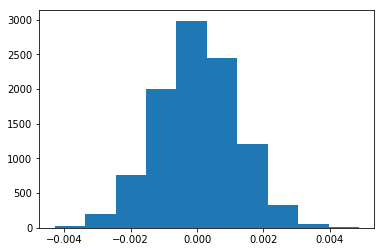

In [145]:
# visual the differenct between new page and old page has been converted  
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

In [146]:
# get obsevation of diffencece
ob_diffs=ob_new-ob_old
print(ob_diffs)
(ob_diffs<p_diffs).mean()

-0.00157823898536


0.90780000000000005

**we are computed in part J is the p_value.Since we get 0.9 on our p-value. The critical value is 0.05. 0.9 is greater than 0.05. 
 we can state that there is no significant evidence to reject null  and concluded that there is no much difference between new page and old page.**  

In [147]:
import statsmodels.api as sm
# get number of converted by old page
convert_old = sum(df2.query('group == "control"')['converted'])
convert_new = sum(df2.query('group == "treatment"')['converted'])
n_old = df2.query('group == "control"').count()[0]
n_new = df2.query('group == "control"').count()[0] 

In [148]:
# using stats.proportions_ztest to get z score and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score,p_value)

-1.28632078586 0.900834434411


** the results of z_score and p_value agree with j, k. The z_score show a negative value which means we fail to reject Null hypothesis. The p_value is same as K.**

<a id='regression'></a>
### Part III - A regression approach



**logistic regression may apply here since we can use the column of 'converted' as our response variable**

In [149]:
#Create intercept 
df2['intercept']=1

#Create dummy variables 
df2[['control', 'treatment']] = pd.get_dummies(df['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


In [150]:
# conduct a logistic regression mode
logit_mod=sm.Logit(df2.converted,df2[['intercept','treatment']])


In [151]:
results=logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 21 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        07:15:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


** The p-value is 0.19 which is also insignifcance and fail to reject null. **
$$H_0:p_{new} =p_{old}$$
$$H_1:p_{new}!=p_{old}$$
**p-value is different because the hypothsis test is different**

In [152]:
# concat countries and df2
df_countries=pd.read_csv('countries.csv')
df_countries.head()
df_new=df2.set_index('user_id').join(df_countries.set_index('user_id'))
df_new.head()

,timestamp,group,landing_page,converted,intercept,control,treatment,country
user_id,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA


In [153]:
#get dummy variables
country_dummy=pd.get_dummies(df_new.country)
country_dummy
df_final=df_new.join(country_dummy)


In [154]:
df_final.head()

,timestamp,group,landing_page,converted,intercept,control,treatment,country,CA,UK,US
user_id,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0


In [156]:
# create interaction colunm by multiply treament with country dummy variables
df_final['us_page']=df_final['treatment']*df_final['US']
df_final['uk_page']=df_final['treatment']*df_final['UK']
df_final.head()

,timestamp,group,landing_page,converted,intercept,control,treatment,country,CA,UK,US,us_page,uk_page
user_id,,,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,1,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0,0,1
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0,0,0


In [157]:
#conduct a logistic regression mode with countries

logit_mod_final=sm.Logit(df_final.converted,df_final[['intercept','US','UK','treatment','us_page','uk_page']])
final_results=logit_mod_final.fit()
final_results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        07:17:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
treatment     -0.0674      0.052     -1.297      0.195      -0.169       0.034
us_page        0.0469      0.054      0.872      0.383      -0.059       0.152
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
==============================================================================
"""


## conclustion
we can conclued that the new page is not better than old page so we decided to keep the old page,
the p-value of country and treatment are greater that critical value 0.05 so they are not signicance.
In addition,the interaction between countries and page is not signicance as well.
The statistical results suggest keeping old page.
For the practical reasoning is same since old page seems better than new page.

ref:
   
    https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python$$
    
    https://pandas.pydata.org/pandas-docs/stable/merging.html